In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
text = open('Text.txt', 'r').read().lower()

In [3]:
text[:10]

'au lecteur'

In [4]:
chars = sorted(list(set(''.join(text))))
string_to_index = {s:i for i,s in enumerate(chars)}

In [5]:
N = torch.zeros((35, 35), dtype=torch.int32)

In [6]:
for ch1, ch2 in zip(text, text[1:]):
    N[string_to_index[ch1], string_to_index[ch2]] += 1

In [7]:
index_to_string = {i:s for s,i in string_to_index.items()}

(-0.5, 34.5, 34.5, -0.5)

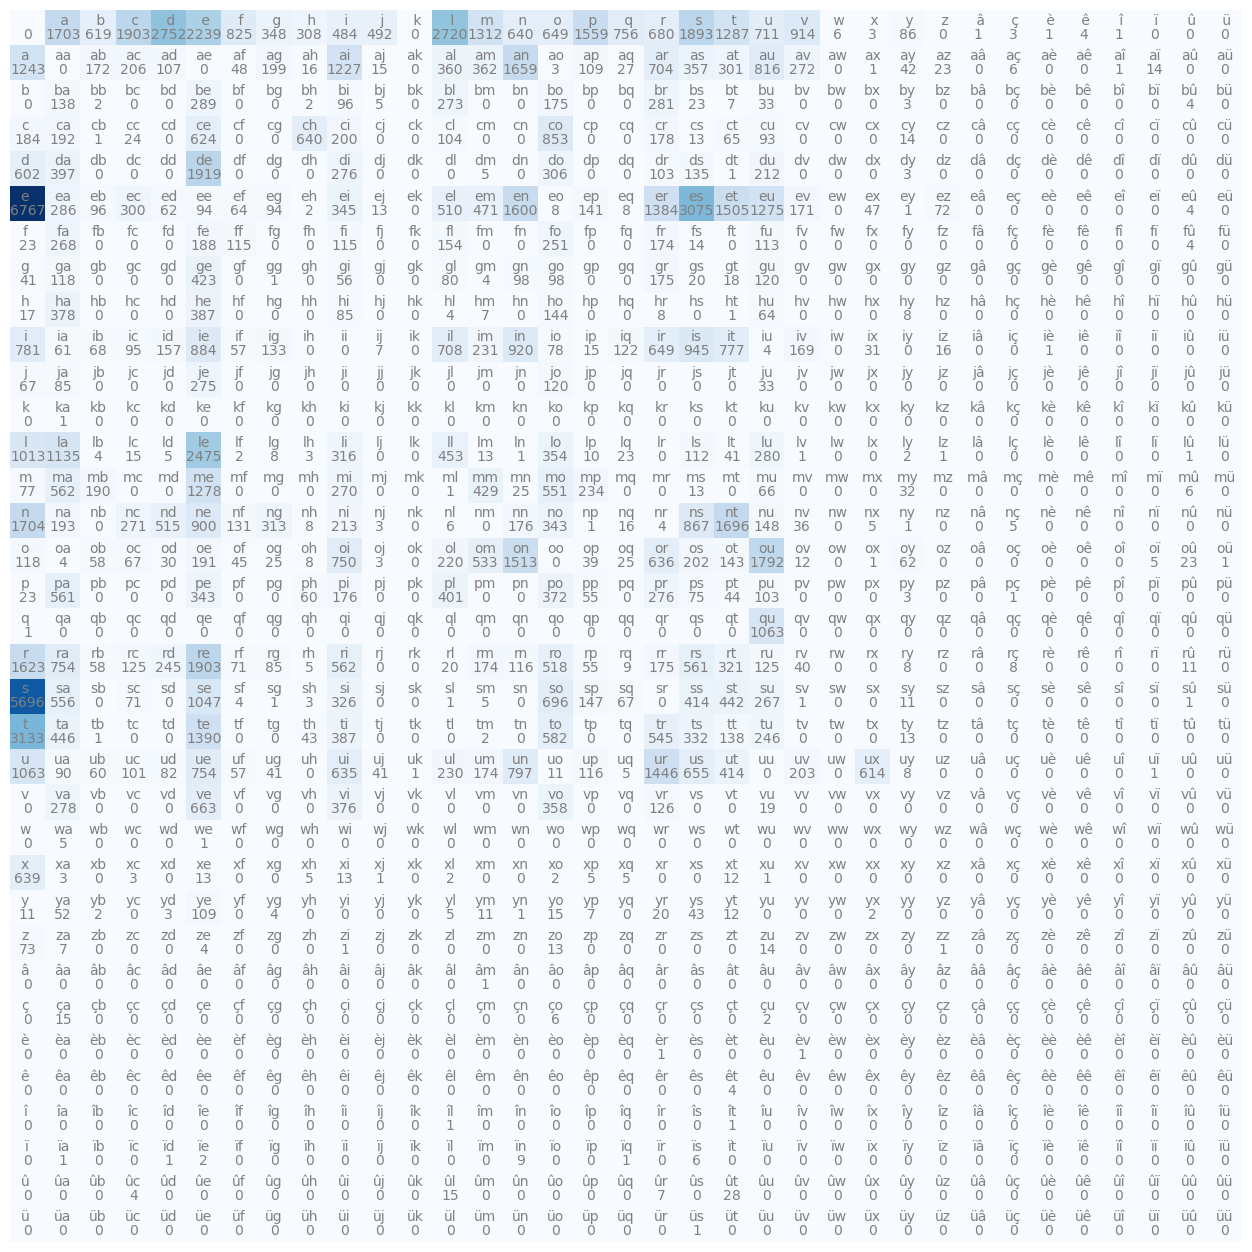

In [8]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(35):
    for j in range(35):
        chstr = index_to_string[i] + index_to_string[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i,j].item(), ha='center', va='top', color='gray')
plt.axis('off')

In [9]:
P = N.float()
P = P / P.sum(1, keepdim=True)

In [46]:
g = torch.Generator()

out = []
ix = torch.multinomial(P[0], num_samples=1, replacement=True, generator=g).item()
for i in range(40):
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(index_to_string[ix])
print(''.join(out))
    


omiriloton ateva d aret es cloes s tes v


In [69]:
N2 = torch.zeros((35*35, 35), dtype=torch.int32)

In [70]:
for ch1, ch2, ch3 in zip(text, text[1:], text[2:]):
    N2[string_to_index[ch1]*35+string_to_index[ch2], string_to_index[ch3]] += 1

In [71]:
P2 = N2.float()
P2 = P2 / P2.sum(1, keepdim=True)

In [73]:
out = []
ix1 = torch.multinomial(P[0], num_samples=1, replacement=True, generator=g).item()
out.append(index_to_string[ix1])
ix2 = torch.multinomial(P[ix1], num_samples=1, replacement=True, generator=g).item()
out.append(index_to_string[ix2])
for i in range(40):
    p2 = P2[ix1*35+ix2]
    ix3 = torch.multinomial(p2, num_samples=1, replacement=True, generator=g).item()
    out.append(index_to_string[ix3])
    ix1 = ix2
    ix2 = ix3
print(''.join(out))

leupiels la fet de pet le obste ens tontis


In [101]:
loglikelihood1, loglikelihood2 = 0, 0
n = 0

for ch1, ch2, ch3 in zip(text, text[1:], text[2:]):
    ix1 = string_to_index[ch1]
    ix2 = string_to_index[ch2]
    ix3 = string_to_index[ch3]

    prob1 = P[ix2, ix3]
    prob2 = P2[ix1*35+ix2, ix3]

    loglikelihood1 += torch.log(prob1)
    loglikelihood2 += torch.log(prob2)
    n += 1

print(f'Negative log likelihood random ={-np.log(1/35)}')
print(f'Negative log likelihood bigram ={-loglikelihood1}')
print(f'Mean = {-loglikelihood1/n:4f}')
print(f'Negative log likelihood trigram ={-loglikelihood2}')
print(f'Mean = {-loglikelihood2/n:4f}')

Negative log likelihood random =3.5553480614894135
Negative log likelihood bigram =295852.0
Mean = 2.204988
Negative log likelihood trigram =244083.734375
Mean = 1.819158


In [75]:
words = text.split(' ')
print(len(set(words)))

5462


In [76]:
Nw = torch.zeros((5462, 5462), dtype=torch.int32)

In [79]:
words_to_index = {s:i for i,s in enumerate(set(words))}

In [80]:
index_to_words = {i:s for s,i in words_to_index.items()}

In [88]:
for w1, w2 in zip(words, words[1:]):
    Nw[words_to_index[w1], words_to_index[w2]] += 1

In [89]:
Pw = Nw.float()
Pw = Pw / Pw.sum(1, keepdim=True)

In [90]:
out = []
ix = 0
for i in range(40):
    p = Pw[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(index_to_words[ix]+' ')
print(''.join(out))

des bois car j aiguisais lentement se pavane avec la fecondite nous pour rassasier ma sombre et pourtant nous avons travaille c est enferme et cependant qu en vont vers l orchestre sonore une antique momie dessins auxquels la girouette 


In [102]:
loglikelihood = 0
n = 0

for w1, w2 in zip(words, words[1:]):
    ix1 = words_to_index[w1]
    ix2 = words_to_index[w2]

    prob = Pw[ix1, ix2]

    loglikelihood += torch.log(prob)
    n += 1

print(f'Negative log likelihood random words ={-np.log(1/len(set(words)))}')
print(f'Negative log likelihood word-gram ={-loglikelihood}')
print(f'Mean = {-loglikelihood/n}')

Negative log likelihood random words =8.60557030203365
Negative log likelihood word-gram =68256.1015625
Mean = 2.741318941116333


In [115]:
xs, ys = [], []

for ch1, ch2 in zip(text, text[1:]):
    xs.append(string_to_index[ch1])
    ys.append(string_to_index[ch2])

xs, ys = torch.tensor(xs), torch.tensor(ys)
num = xs.nelement()

In [117]:
W = torch.randn((35,35), generator=g, requires_grad=True)

In [124]:
xhot = F.one_hot(xs, num_classes=35).float()
old_loss = 100
ite = 0
while True:
    logits = xhot @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean()

    W.grad = None
    loss.backward()

    W.data += -50 * W.grad

    if np.abs(old_loss-loss.item())<0.00001:
        print(f'Final loss after {ite} interations is {loss.item()}')
        break
    old_loss = loss.item()
    ite +=1

Final loss after 433 interations is 2.21195912361145


In [128]:
out = []
ix = 0
for i in range(40):
    xhot = F.one_hot(torch.tensor([ix]), num_classes=35).float()
    logits = xhot @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    out.append(index_to_string[ix]+' ')
print(''.join(out))

lame pourquoi avions supplicies tache araignees rentrer mouilles lamentables clair craigne mouilles lamentables mouilles soeurs rentrer lamentables prisons mais alimentons lisons rentrer debris rentrer durant craigne lamentables gratte rentrer reveusement alimentons rentrer lamentables mouches rentrer clair broie gratte alimentons lisons 


In [163]:
x2s, y2s = [], []

for ch1, ch2, ch3 in zip(text, text[1:], text[2:]):
    x2s.append(string_to_index[ch1]+string_to_index[ch2])
    y2s.append(string_to_index[ch3])

x2s, y2s = torch.tensor(x2s), torch.tensor(y2s)
num = x2s.nelement()

W2 = torch.randn((35*35,35), generator=g, requires_grad=True)

In [167]:
x2hot = F.one_hot(x2s, num_classes=35*35).float()

for i in range(100):
    logits = x2hot @ W2
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(num), y2s].log().mean()

    W2.grad = None
    loss.backward()

    W2.data += -100 * W2.grad

print(f'Final loss is {loss.item()}')

Final loss is 2.44804048538208


In [ ]:
out = []
ix = 0
for i in range(40):
    x2hot = F.one_hot(torch.tensor([ix]), num_classes=35*35).float()
    logits = x2hot @ W2
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    out.append(index_to_string[ix]+' ')
print(''.join(out))

In [241]:
n1, n2 = int(0.8*len(words)), int(0.9*len(words))
n1

19920

In [393]:
def build_dataset(text):
    block_size = 3
    X, Y = [], []


    context = [0]*block_size
    for ch in text:
        ix = string_to_index[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

    return torch.tensor(X), torch.tensor(Y)

Xtr, Ytr = build_dataset(text[:n1])
Xval, Yval = build_dataset(text[n1:n2])
Xte, Yte = build_dataset(text[n2:])

In [404]:
C = torch.randn((35, 10), requires_grad=True)
W1 = torch.randn((30,200), requires_grad=True)
b1 = torch.randn(200, requires_grad=True)
W2 = torch.randn((200, 35), requires_grad=True)
b2 = torch.randn(35, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [369]:
sum(p.nelement() for p in parameters)

17585

In [249]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [306]:
lri, lossi, niter = [], [], []

In [405]:
old_loss = 100
ite = 0

while True :
    ix = torch.randint(0, Xtr.shape[0]-32, (1,)) + torch.arange(32)
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 +b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 10**-0.6
    for p in parameters:
        p.data += -lr*p.grad
    
    #lri.append(lre[ite])
    lossi.append(loss.log10().item())
    niter.append(ite)
    if np.abs(old_loss-loss.item())<0.00001:
        print(f'Final loss after {ite} interations is {loss.item()}')
        break
    
    if ite > 50000:
        break
    old_loss = loss.item()
    ite +=1

Final loss after 17866 interations is 2.218043804168701


In [406]:
emb = C[Xval]
h = torch.tanh(emb.view(-1,30) @ W1 +b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
print(f'Loss on validation set is {loss.item():4f}')

Loss on validation set is 2.567325


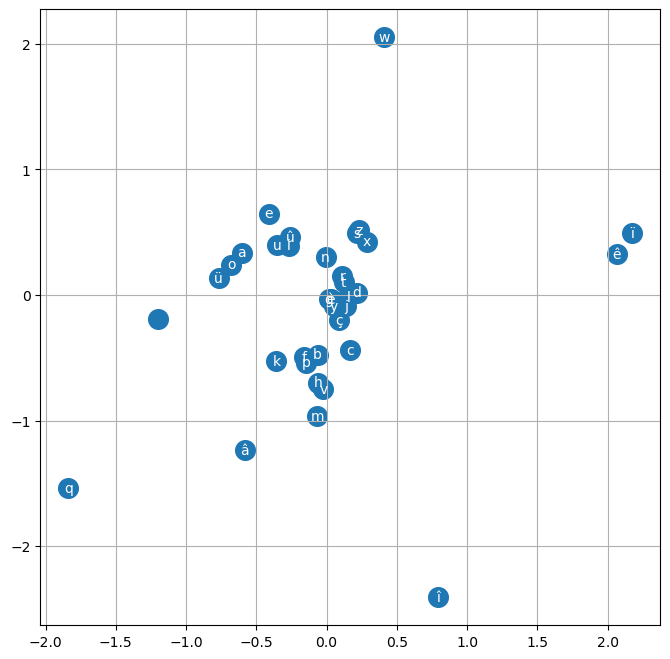

In [314]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), index_to_string[i], ha='center', va='center', color='white')
plt.grid('minor')

In [411]:
out = []
context = [0]*3

for _ in range(40):
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2        
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()        
    context = context[1:] + [ix]
    out.append(ix)

print(''.join(index_to_string[i] for i in out))

pore et unite est plent averait eclos un


In [427]:
def build_dataset(words):
    block_size = 5
    X, Y = [], []


    context = [0]*block_size
    for w in words:
        ix = words_to_index[w]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

    return torch.tensor(X), torch.tensor(Y)

nw1, nw2 = int(0.8*len(words)), int(0.9*len(words))
Xwtr, Ywtr = build_dataset(words[:nw1])
Xwval, Ywval = build_dataset(words[nw1:nw2])
Xwte, Ywte = build_dataset(words[nw2:])

In [450]:
intwords = int(len(set(words)))
Cw = torch.randn((intwords, 50), requires_grad=True)
Ww1 = torch.randn((250,100), requires_grad=True)
bw1 = torch.randn(100, requires_grad=True)
Ww2 = torch.randn((100, intwords), requires_grad=True)
bw2 = torch.randn(intwords, requires_grad=True)
parameters = [Cw, Ww1, bw1, Ww2, bw2]

In [451]:
old_loss = 100
ite = 0

while True :
    ix = torch.randint(0, Xwtr.shape[0]-32, (1,)) + torch.arange(32)
    emb = Cw[Xwtr[ix]]
    h = torch.tanh(emb.view(-1, 250) @ Ww1 +bw1)
    logits = h @ Ww2 + bw2
    loss = F.cross_entropy(logits, Ywtr[ix])

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 10**-0.6
    for p in parameters:
        p.data += -lr*p.grad
    
    #lri.append(lre[ite])
    lossi.append(loss.log10().item())
    niter.append(ite)
    if np.abs(old_loss-loss.item())<0.00001:
        print(f'Final loss after {ite} interations is {loss.item()}')
        break
    
    if ite > 50000:
        break
    old_loss = loss.item()
    ite +=1

In [452]:
emb = Cw[Xwval]
h = torch.tanh(emb.view(-1,250) @ Ww1 +bw1)
logits = h @ Ww2 + bw2
loss = F.cross_entropy(logits, Ywval)
print(f'Loss on validation set is {loss.item():4f}')

Loss on validation set is 16.163536


In [457]:
out = []
context = [0]*5

for _ in range(40):
    emb = Cw[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ Ww1 + bw1)
    logits = h @ Ww2 + bw2        
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()        
    context = context[1:] + [ix]
    out.append(ix)

print(''.join(index_to_words[i]+' ' for i in out))

l homme un douceur de evanouir non une fraternite brûlants s dans ou je s un secret les font dans la astrologues nausees ta l homme dans des femmes effrayant o poetes des pinceau et le roi pour s dans 
